In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

import re



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
df = pd.read_csv('smile-annotations-final.csv', names=['id', 'text', 'category'])
df.set_index('id', inplace=True)

In [5]:
df.head()

,text,category
id,,
611857364396965889,@aandraous @britishmuseum @AndrewsAntonio Merc...,nocode
614484565059596288,Dorian Gray with Rainbow Scarf #LoveWins (from...,happy
614746522043973632,@SelectShowcase @Tate_StIves ... Replace with ...,happy
614877582664835073,@Sofabsports thank you for following me back. ...,happy
611932373039644672,@britishmuseum @TudorHistory What a beautiful ...,happy


In [6]:
df.category.value_counts()

nocode               1572
happy                1137
not-relevant          214
angry                  57
surprise               35
sad                    32
happy|surprise         11
happy|sad               9
disgust|angry           7
disgust                 6
sad|disgust             2
sad|angry               2
sad|disgust|angry       1
Name: category, dtype: int64

In [7]:
df = df[~df.category.str.contains('\|')]

In [8]:
df = df[df.category != 'nocode']

In [9]:
val_count = df.category.value_counts()

Text(0.5, 1.0, 'Sentiment Data Distribution')

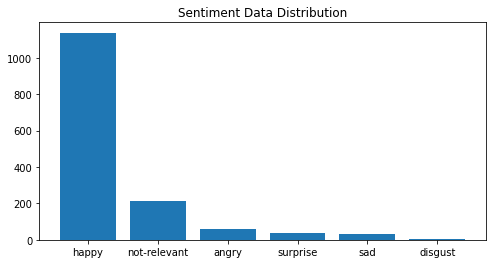

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Sentiment Data Distribution")

In [11]:
possible_labels = df.category.unique()

In [12]:
label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index

In [13]:
df['label'] = df.category.replace(label_dict)

In [14]:
df.head()

,text,category,label
id,,,
614484565059596288,Dorian Gray with Rainbow Scarf #LoveWins (from...,happy,0
614746522043973632,@SelectShowcase @Tate_StIves ... Replace with ...,happy,0
614877582664835073,@Sofabsports thank you for following me back. ...,happy,0
611932373039644672,@britishmuseum @TudorHistory What a beautiful ...,happy,0
611570404268883969,@NationalGallery @ThePoldarkian I have always ...,happy,0


Looks like we have a nasty data in text. Because in general we use lot of punctuations and other words without any contextual meaning. It has no value as feature to the model we are training. So we need to get rid of them.

# **Text Preprocessing**

In [15]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

In [16]:
import re
def preprocess(text, stem=False):
  text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
  tokens = []
  for token in text.split():
    if token not in stop_words:
      if stem:
        tokens.append(stemmer.stem(token))
      else:
        tokens.append(token)
  return " ".join(tokens)

In [17]:
df.text = df.text.apply(lambda x: preprocess(x))

In [18]:
df.head()

,text,category,label
id,,,
614484565059596288,dorian gray rainbow scarf lovewins britishmuseum,happy,0
614746522043973632,tate stives replace wish artist uses next inst...,happy,0
614877582664835073,thank following back great hear diverse amp in...,happy,0
611932373039644672,tudorhistory beautiful jewel portrait r rex,happy,0
611570404268883969,thepoldarkian always loved painting,happy,0




# **Word Clouds**



Happy

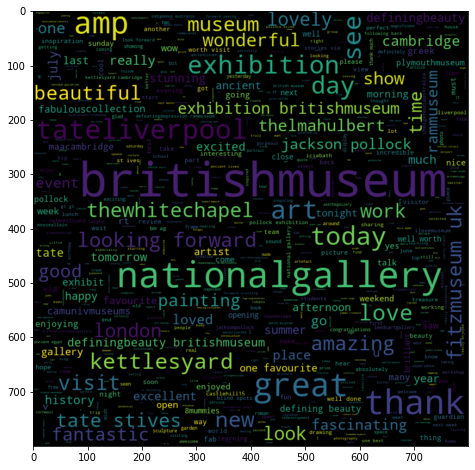

In [19]:
from wordcloud import WordCloud

plt.figure(figsize = (12,8)) 
wc = WordCloud(max_words = 2000 , width = 800 , height = 800).generate(" ".join(df[df.category == 'happy'].text))
plt.imshow(wc , interpolation = 'bilinear')

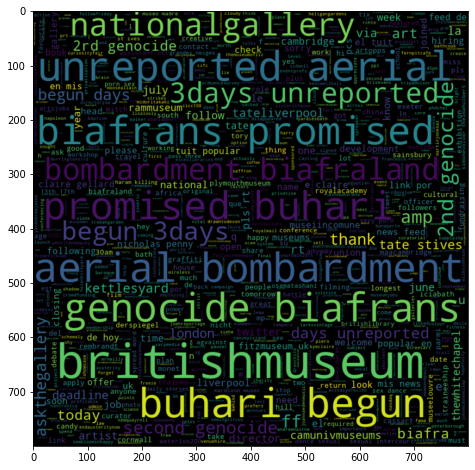

In [20]:
plt.figure(figsize = (12,8)) 
wc = WordCloud(max_words = 2000 , width = 800 , height = 800).generate(" ".join(df[df.category == 'not-relevant'].text))
plt.imshow(wc , interpolation = 'bilinear')

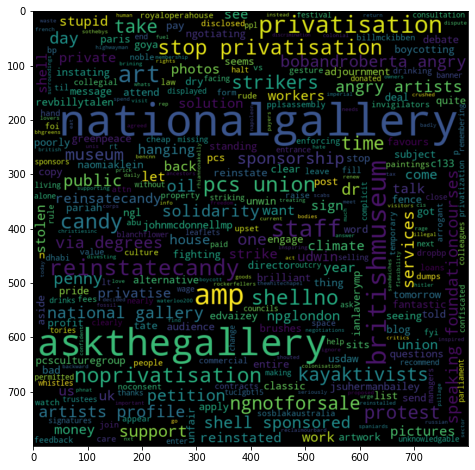

In [21]:
plt.figure(figsize = (12,8)) 
wc = WordCloud(max_words = 2000 , width = 800 , height = 800).generate(" ".join(df[df.category == 'angry'].text))
plt.imshow(wc , interpolation = 'bilinear')

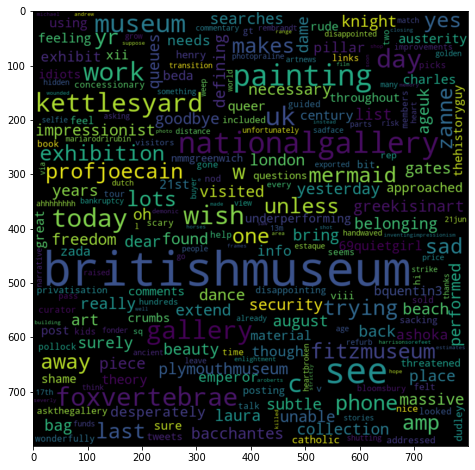

In [22]:
plt.figure(figsize = (12,8)) 
wc = WordCloud(max_words = 2000 , width = 800 , height = 800).generate(" ".join(df[df.category == 'sad'].text))
plt.imshow(wc , interpolation = 'bilinear')

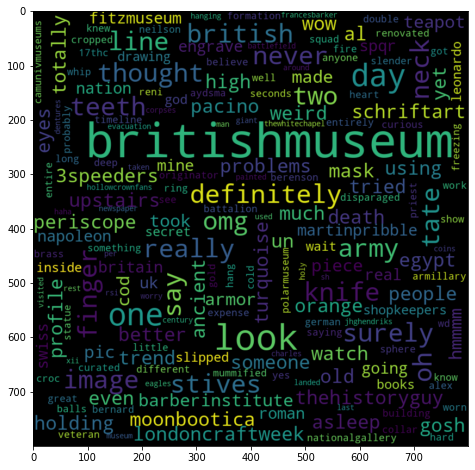

In [23]:
plt.figure(figsize = (12,8)) 
wc = WordCloud(max_words = 2000 , width = 800 , height = 800).generate(" ".join(df[df.category == 'surprise'].text))
plt.imshow(wc , interpolation = 'bilinear')

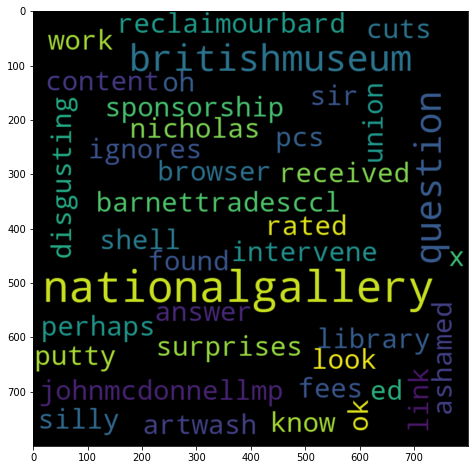

In [24]:
plt.figure(figsize = (12,8)) 
wc = WordCloud(max_words = 2000 , width = 800 , height = 800).generate(" ".join(df[df.category == 'disgust'].text))
plt.imshow(wc , interpolation = 'bilinear')

# **Training/Validation Split**

In [25]:
from sklearn.model_selection import train_test_split
#85% for training and 15% for testing
X_train, X_val, y_train, y_val = train_test_split(df.index.values, 
                                                  df.label.values, 
                                                  test_size=0.15, 
                                                  random_state=17, 
                                                  stratify=df.label.values)

In [26]:
df['data_type'] = ['not_set']*df.shape[0]

In [27]:
df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

In [28]:
df.groupby(['category', 'label', 'data_type']).count()

text
category     label data_type      
angry        2     train        48
                   val           9
disgust      3     train         5
                   val           1
happy        0     train       966
                   val         171
not-relevant 1     train       182
                   val          32
sad          4     train        27
                   val           5
surprise     5     train        30
                   val           5

# **Tokenisation**

In [29]:
#tokenizer create tokens for every word in the data corpus and map them to a index using dictionary.
#word_index contains the index for each word
#vocab_size represents the total number of word in the data corpus

from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df[df.data_type=='train'].text)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 3921


Now we got a tokenizer object, which can be used to covert any word into a Key in dictionary (number).

Since we are going to build a sequence model. We should feed in a sequence of numbers to it. And also we should ensure there is no variance in input shapes of sequences. It all should be of same length. But texts in tweets have different count of words in it. To avoid this, we seek a little help from pad_sequence to do our job. It will make all the sequence in one constant length MAX_SEQUENCE_LENGTH.

In [30]:
from keras_preprocessing.sequence import pad_sequences
MAX_SEQUENCE_LENGTH= 30

x_train = pad_sequences(tokenizer.texts_to_sequences(df[df.data_type=='train'].text),
                        maxlen = MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df[df.data_type=='val'].text),
                       maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

Training X Shape: (1258, 30)
Testing X Shape: (223, 30)


In [31]:
print("y_train shape:", y_train.shape)
print("y_test shape:", y_val.shape)

y_train shape: (1258,)
y_test shape: (223,)


In [32]:
from tensorflow.keras.utils import to_categorical
yTrain = to_categorical(y_train, 6)
yVal = to_categorical(y_val, 6)

In [33]:
print("y_train shape:", yTrain.shape)
print("y_val shape:", yVal.shape)

y_train shape: (1258, 6)
y_val shape: (223, 6)


# **Word Embedding**



Word Embedding is a feature vector representation of words which are used for natural language processing applications.

We could train the embedding ourselves but that would take a while to train and it wouldn't be effective. So going in the path of Computer Vision, here we use Transfer Learning. We download the pre-trained embedding and use it in our model.

The pretrained Word Embedding like GloVe & Word2Vec gives more insights for a word which can be used for classification. GloVe embedding has been used here.

In [34]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2022-12-08 21:24:31--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-12-08 21:24:31--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-12-08 21:24:32--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [35]:
GLOVE_EMB = '/content/glove.6B.300d.txt'
EMBEDDING_DIM = 300
LR = 1e-3
BATCH_SIZE = 1024
EPOCHS = 10
MODEL_PATH = '.../content/best_model.hdf5'

In [36]:
embeddings_index = {}

f = open(GLOVE_EMB)
for line in f:
  values = line.split()
  word = value = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.


In [37]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [38]:
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                          EMBEDDING_DIM,
                                          weights=[embedding_matrix],
                                          input_length=MAX_SEQUENCE_LENGTH,
                                          trainable=False)

# **Model Training**

In [39]:
#For model architecture, we use
#1) Embedding Layer - Generates Embedding Vector for each input sequence.
#2) Conv1D Layer - Its using to convolve data into smaller feature vectors.
#3) LSTM - Long Short Term Memory, its a variant of RNN which has memory state cell to learn the context of words which are at further along the text to carry contextual meaning rather than just neighbouring words as in case of RNN.
#4) Dense - Fully Connected Layers for classification

from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint


In [40]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(64, 5, activation='relu')(x)
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(6, activation='softmax')(x)
model = tf.keras.Model(sequence_input, outputs)

Callbacks

Callbacks are special functions which are called at the end of an epoch. We can use any functions to perform specific operation after each epoch. I used two callbacks here,

LRScheduler - It changes a Learning Rate at specfic epoch to achieve more improved result.

ModelCheckPoint - It saves best model while training based on some metrics. Here, it saves the model with minimum Validity Loss.

In [41]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

model.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy',
              metrics=['accuracy'])
ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1,
                                     min_lr = 0.01,
                                     monitor = 'val_loss',
                                     verbose = 1)

# **Training the Model**

In [42]:
print("Training on GPU...") if tf.test.is_gpu_available() else print("Training on CPU...")

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Training on GPU...


In [43]:
history = model.fit(x_train, yTrain, batch_size=BATCH_SIZE, epochs=20,
                    validation_data=(x_test, yVal), callbacks=[ReduceLROnPlateau])

Epoch 1/20
2/2 [==============================] - 13s 841ms/step - loss: 0.6914 - accuracy: 0.3784 - val_loss: 0.6240 - val_accuracy: 0.7668 - lr: 0.0010
Epoch 2/20
2/2 [==============================] - 0s 254ms/step - loss: 0.5985 - accuracy: 0.7679 - val_loss: 0.4864 - val_accuracy: 0.7668 - lr: 0.0010
Epoch 3/20
2/2 [==============================] - 0s 265ms/step - loss: 0.4475 - accuracy: 0.7679 - val_loss: 0.3154 - val_accuracy: 0.7668 - lr: 0.0010
Epoch 4/20
2/2 [==============================] - 0s 269ms/step - loss: 0.2971 - accuracy: 0.7679 - val_loss: 0.2724 - val_accuracy: 0.7668 - lr: 0.0010
Epoch 5/20
2/2 [==============================] - 1s 283ms/step - loss: 0.2868 - accuracy: 0.7679 - val_loss: 0.2705 - val_accuracy: 0.7668 - lr: 0.0010
Epoch 6/20
2/2 [==============================] - 0s 226ms/step - loss: 0.2874 - accuracy: 0.7679 - val_loss: 0.2635 - val_accuracy: 0.7668 - lr: 0.0010
Epoch 7/20
2/2 [==============================] - 0s 249ms/step - loss: 0.2709 - 

# **Model Evaluation**

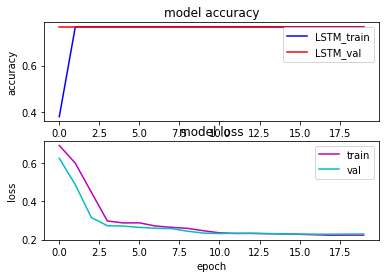

In [44]:
s, (at, al) = plt.subplots(2,1)
at.plot(history.history['accuracy'], c= 'b')
at.plot(history.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['LSTM_train', 'LSTM_val'], loc='best')

al.plot(history.history['loss'], c='m')
al.plot(history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'best')

In [45]:
from sklearn.metrics import classification_report
y_pred = np.argmax(yVal, 1)
y_true= np.argmax(model.predict(x_test), axis=1)

print(classification_report(y_pred, y_true))

7/7 [==============================] - 1s 19ms/step
              precision    recall  f1-score   support

           0       0.77      1.00      0.87       171
           1       0.00      0.00      0.00        32
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00         5

    accuracy                           0.77       223
   macro avg       0.13      0.17      0.14       223
weighted avg       0.59      0.77      0.67       223



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [46]:
from sklearn.metrics import confusion_matrix

#Generate the confusion matrix
cf_matrix = confusion_matrix(y_pred, y_true)


Happy	0

Not-relevant	1

Angry	2

Disgust	3

Sad	4

Surprise	5


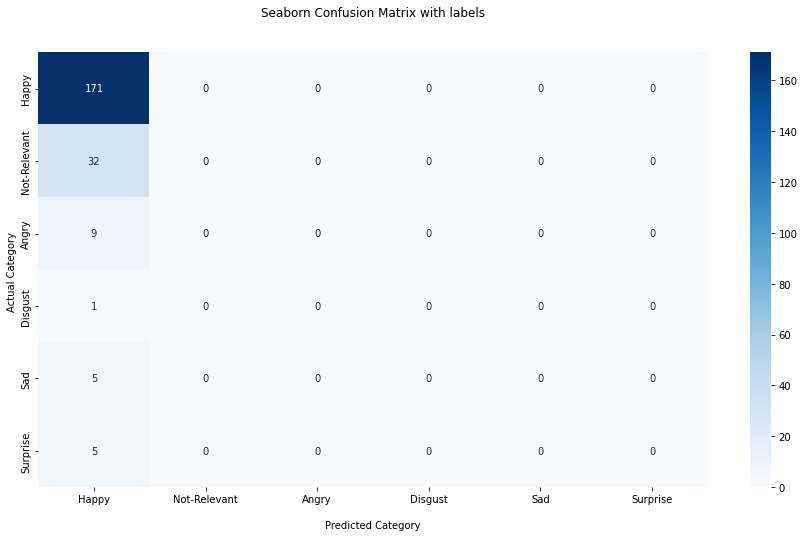

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 8))
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues',fmt="d")

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Category')
ax.set_ylabel('Actual Category ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(["Happy","Not-Relevant","Angry","Disgust","Sad","Surprise"])
ax.yaxis.set_ticklabels(["Happy","Not-Relevant","Angry","Disgust","Sad","Surprise"])

## Display the visualization of the Confusion Matrix.
plt.show()